# Data & Lib

In [15]:
from datetime import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge,Lasso
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [17]:
import pandas as pd
import numpy as np

# Number of weeks
num_weeks = 52

# Generate week numbers
week_numbers = np.arange(1, num_weeks + 1)

# Generate a cyclic component using a sine wave for seasonality
cyclic_component = 10 * np.sin(2 * np.pi * week_numbers / 13)  # 4 cycles per year

# Generate sales data: base value + cyclic component + random noise
sales_data = 50 + cyclic_component + np.random.normal(0, 15, num_weeks)

# Ensure sales are always positive
sales_data = np.maximum(sales_data, 0)

# Create a DataFrame
df = pd.DataFrame({
    'Week': week_numbers,
    'Sales': sales_data
})

print(df)


    Week      Sales
0      1  69.071573
1      2  62.870715
2      3  81.112373
3      4  53.803524
4      5  70.103760
5      6  70.058552
6      7  30.345128
7      8  53.696870
8      9  35.420488
9     10  46.291605
10    11  35.469316
11    12  50.773088
12    13  36.274617
13    14  35.756899
14    15  62.781596
15    16  52.188380
16    17  55.021131
17    18  73.945715
18    19  43.840163
19    20  60.228548
20    21  42.209019
21    22  47.347191
22    23  29.149987
23    24  27.642353
24    25  61.876236
25    26  27.123059
26    27  51.032732
27    28  22.860840
28    29  73.177820
29    30  72.424732
30    31  67.148126
31    32  61.311019
32    33  46.623378
33    34  44.930613
34    35  48.423198
35    36  53.798210
36    37  46.396305
37    38  27.331086
38    39  62.313519
39    40  48.423324
40    41  75.353046
41    42  47.773163
42    43  50.188839
43    44  76.147220
44    45  35.415398
45    46  49.918504
46    47  42.283861
47    48  51.738855
48    49  40.958459


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

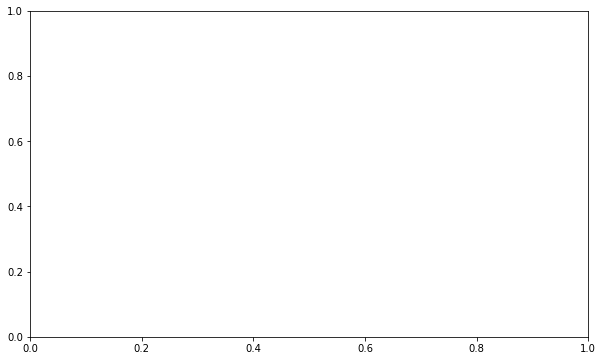

In [18]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Week'], df['Sales'], marker='o')
plt.title('Weekly Sales with Cyclical Behavior')
plt.xlabel('Week Number')
plt.ylabel('Sales')
plt.grid(True)
plt.show()